In [1]:
import re
import sys
import phik
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import set_config
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from IPython.display import display_html 
from sklearn.cluster import AgglomerativeClustering

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [2]:
assert sys.version_info >= (3, 7, 3)
assert sklearn.__version__ == '0.23.2'

In [3]:
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,8)

# Display estimators as diagrams in Jupyter notebook
set_config(display='diagram')

In [4]:
# Configure precision to diplay pandas
pd.options.display.precision = 2

# Set maximum pandas column width
pd.options.display.max_colwidth = 25


def setNanWhite(val):
    """ Colour NaN text white """
    if np.isnan(val):
        return 'color: white'


def displayInline(*dfs, spaces=10):
    """ Display pandas dataframes as inline """
    html = ''
    seperator = '<table style=\'display:inline\'>' + (f'{"&nbsp"*spaces}')
    inline = "style='display:inline'"
    for i, df in enumerate(dfs):
        if isinstance(df, pd.io.formats.style.Styler):
            styler = df
        else:
            styler = df.style
        html += styler.set_table_attributes(inline)._repr_html_() 
        # Don't add seperator to last element
        if i < len(dfs) - 1:
            html += seperator
    return display_html(html, raw=True)


def plotSummaryCount(df, groups, feature, summary='mean', fillna=True, prop=True):
    """ Summarise a grouped dataframe, including sample size per group
        and display inline """
    # Create local copy of the required columns
    sub_df = df.loc[:, [*groups, feature]]
    for group in groups:
        # Boolean groups causes issues so map to string
        if pd.api.types.is_bool_dtype(sub_df[group]):
            sub_df[group] = sub_df[group].astype(str)
        # Convert groups to categories
        sub_df[group] = sub_df[group].astype('category')
        # Replace missing data with string so it is included as a group
        if fillna and sub_df[group].isnull().values.any():
            sub_df[group] = (
                sub_df[group].cat.add_categories('Unknown')
                .fillna('Unknown'))
    grouped_df = sub_df.groupby(groups)
    countGroup = grouped_df.size().fillna(0)
    if prop:
        countGroup /= countGroup.sum()
    summaryGroup = grouped_df[feature].agg(summary)
    if len(groups) == 1:
        summaryGroup = summaryGroup.to_frame()
        countGroup = countGroup.to_frame()
    else:
        summaryGroup = summaryGroup.unstack()
        countGroup = countGroup.unstack()
    summaryGroup = (summaryGroup
        .style.background_gradient(cmap='Blues', axis=None)
        .highlight_null('white').applymap(setNanWhite)
        .set_caption(f'{feature} ({summary})'))
    countGroup = (countGroup
        .style.background_gradient(cmap='Blues', axis=None)
        .set_caption('Sample size'))
    
    return displayInline(summaryGroup, countGroup)


def roundInterval(x):
    """ Round intervals """
    return pd.Interval(
        left=int(round(x.left)), 
        right=int(round(x.right)))

In [5]:
# Define paths to datasets and target/feature information
trainPath = 'train.csv'
testPath = 'test.csv'
target = 'Survived'
index = 'PassengerId'

In [6]:
# Explicity define datatypes
dtypes = ({
    'Survived': bool, 
    'Pclass':   'category', 
    'Name':     'category',
    'Sex':      'category',
    'Age':      float,
    'SibSp':    int,
    'Parch':    int,
    'Ticket':  'category',
    'Fare':     float,
    'Cabin':   'category',
    'Embarked':'category'
})
# Read training data
train = pd.read_csv(trainPath, index_col=index, dtype=dtypes)
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S
2,True,1,"Cumings, Mrs. John Br...",female,38.0,1,0,PC 17599,71.28,C85,C
3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.92,NaN,S
4,True,1,"Futrelle, Mrs. Jacque...",female,35.0,1,0,113803,53.10,C123,S
5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,NaN,S


## Exploratory Data Analysis
 - Here we explore the training dataset and relationships between features.
 - We also explore possible new features to engineer.
 - Test dataset is ignored.

### View missing data

In [7]:
def showMissing(df):
    """ Show features with missing values """
    nullOrd = df.isnull().sum().sort_values(ascending=False)
    nullOrd = nullOrd[nullOrd > 0]
    nullOrd = pd.DataFrame(nullOrd, columns=['TotalNA'])
    nullOrd['PropNA'] = nullOrd['TotalNA'] / len(df)
    return nullOrd.style.background_gradient(cmap='Blues')

showMissing(train)

,TotalNA,PropNA
Cabin,687,0.77
Age,177,0.20
Embarked,2,0.00


### Survival by Sex and Pclass
 - We expect Sex and Class to be strong determinants of survival probability and a quick look confirms this.
 - When studying other factors below (e.g. Age)
 - Key points:
   - Female survival is better than Men, irrespective of Class. 
   - Male survival is better in Class 1 is slighty better than Class 2/3.
   - Female survival is worse (~92% vs 50%) in Class 3 vs Class 1/2.

In [8]:
plotSummaryCount(train, ['Sex', 'Pclass'], 'Survived')

Pclass,1,2,3
Sex,,,
female,0.97,0.92,0.50
male,0.37,0.16,0.14
Pclass,1,2,3
Sex,,,
female,0.11,0.09,0.16
male,0.14,0.12,0.39


## Initial feature engineering
 - Prior to visualising the data there are some additional features we can extract based on our knowledge of the data.
   - **Family Size** (from Parch and SibSp)
     - The sum of Parch and SibSp + 1 gives total family size.
   - **Surname** (from Name)
     - Indicates family grouping.
   - **Deck** (from Cabin)
     - The first letter of Cabin indicates the Deck.

In [350]:
train['FamSize'] = train['Parch'] + train['SibSp'] + 1

In [351]:
plotSummaryCount(train, ['Sex', 'Pclass', 'FamSize'], 'Survived')

Survived (mean) FamSize 1 2 3 4 5 6 7 8 11 Sex Pclass 
 
 female 
 1 
 0.97 
 1.00 
 1.00 
 0.50 
 1.00 
 1.00 
 nan 
 nan 
 nan 
 
 
 2 
 0.91 
 0.89 
 0.93 
 1.00 
 1.00 
 1.00 
 nan 
 nan 
 nan 
 
 
 3 
 0.62 
 0.52 
 0.55 
 0.83 
 0.00 
 0.00 
 0.38 
 0.00 
 0.00 
 
 
 male 
 1 
 0.33 
 0.39 
 0.45 
 1.00 
 nan 
 0.00 
 nan 
 nan 
 nan 
 
 
 2 
 0.10 
 0.07 
 0.47 
 0.25 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 3 
 0.12 
 0.18 
 0.32 
 0.33 
 0.00 
 0.00 
 0.25 
 0.00 
 0.00 
 
            Sample size FamSize 1 2 3 4 5 6 7 8 11 Sex Pclass 
 
 female 
 1 
 0.04 
 0.04 
 0.01 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.04 
 0.02 
 0.02 
 0.01 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.07 
 0.03 
 0.02 
 0.01 
 0.01 
 0.01 
 0.01 
 0.00 
 0.00 
 
 
 male 
 1 
 0.08 
 0.03 
 0.01 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.08 
 0.02 
 0.02 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.30 
 0.03 
 0.03 
 0.00 
 0.00 
 0.01 
 0.00 
 0.00 
 0.00

In [352]:
train['Alone'] = (train['FamSize'] == 1)
plotSummaryCount(train, ['Sex', 'Pclass', 'Alone'], 'Survived')

Survived (mean) Alone False True Sex Pclass 
 
 female 
 1 
 0.97 
 0.97 
 
 
 2 
 0.93 
 0.91 
 
 
 3 
 0.42 
 0.62 
 
 
 male 
 1 
 0.43 
 0.33 
 
 
 2 
 0.28 
 0.10 
 
 
 3 
 0.18 
 0.12 
 
            Sample size Alone False True Sex Pclass 
 
 female 
 1 
 0.07 
 0.04 
 
 
 2 
 0.05 
 0.04 
 
 
 3 
 0.09 
 0.07 
 
 
 male 
 1 
 0.05 
 0.08 
 
 
 2 
 0.04 
 0.08 
 
 
 3 
 0.09 
 0.30

In [353]:
train['Deck'] = train['Cabin'].apply(lambda x: x[0])

In [354]:
plotSummaryCount(train, ['Pclass', 'Deck'], 'Survived')

Deck,A,B,C,D,E,F,G,T,Unknown
Pclass,,,,,,,,,
1,0.47,0.74,0.59,0.76,0.72,nan,nan,0.00,0.47
2,nan,nan,nan,0.75,0.75,0.88,nan,nan,0.44
3,nan,nan,nan,nan,1.00,0.20,0.50,nan,0.24
Deck,A,B,C,D,E,F,G,T,Unknown
Pclass,,,,,,,,,
1,0.02,0.05,0.07,0.03,0.03,0.00,0.00,0.00,0.04
2,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.19
3,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.54


### Title
  - Contains information on age, sex, social status.

In [355]:
train['Title'] = train['Name'].apply(lambda x: re.split(',|\.', x)[1].strip())

In [356]:
(train['Title'].value_counts().to_frame().T
 .style.background_gradient(cmap='Blues', axis=1)
 .set_caption('Sample size by Title'))

,Mr,Miss,Mrs,Master,Dr,Rev,Col,Major,Mlle,Jonkheer,Capt,Mme,Lady,Sir,Ms,Don,the Countess
Title,517,182,125,40,7,6,2,2,2,1,1,1,1,1,1,1,1


In [357]:
# Boolean mask of any title NOT in list
otherTitles = ~train['Title'].isin(['Mr', 'Miss', 'Mrs', 'Master'])
# Replace non-standard titles with other to reduce cardinality.
train.loc[otherTitles, 'Title'] = 'Other'

plotSummaryCount(train, ['Pclass', 'Title'], 'Survived')

Title,Master,Miss,Mr,Mrs,Other
Pclass,,,,,
1,1.00,0.96,0.35,0.98,0.61
2,1.00,0.94,0.09,0.90,0.11
3,0.39,0.50,0.11,0.50,nan
Title,Master,Miss,Mr,Mrs,Other
Pclass,,,,,
1,0.00,0.05,0.12,0.05,0.02
2,0.01,0.04,0.10,0.05,0.01
3,0.03,0.11,0.36,0.05,0.00


In [358]:
train['Surname'] = train['Name'].apply(lambda x: re.split(',', x)[0].strip())

### Fare by Pclass and FamSize

In [359]:
train['FareAdj'] = train['Fare'] / train['FamSize']
train['FareAdj'] = train['FareAdj'].replace(0, np.nan)

plotSummaryCount(train, ['Pclass', 'FamSize'], 'FareAdj', summary='median')

FamSize,1,2,3,4,5,6,7,8,11
Pclass,,,,,,,,,
1,33.76,38.36,27.50,30.00,52.48,43.83,nan,nan,nan
2,13.00,13.00,8.75,9.75,4.60,3.12,nan,nan,nan
3,7.90,7.23,5.25,4.81,5.09,4.85,4.47,5.86,6.32
FamSize,1,2,3,4,5,6,7,8,11
Pclass,,,,,,,,,
1,0.12,0.08,0.03,0.01,0.00,0.00,0.00,0.00,0.00
2,0.12,0.04,0.03,0.01,0.00,0.00,0.00,0.00,0.00
3,0.36,0.06,0.05,0.01,0.01,0.02,0.01,0.01,0.01


### Age

In [360]:
train['ageGroup'] = pd.qcut(train['Age'], 4, precision=1).apply(roundInterval)
plotSummaryCount(train, ['Sex', 'Pclass', 'ageGroup'], 'Survived', summary='mean')

Survived (mean) ageGroup (0, 20] (20, 28] (28, 38] (38, 80] Unknown Sex Pclass 
 
 female 
 1 
 0.93 
 0.93 
 1.00 
 0.97 
 1.00 
 
 
 2 
 1.00 
 0.86 
 0.95 
 0.88 
 1.00 
 
 
 3 
 0.51 
 0.54 
 0.47 
 0.08 
 0.60 
 
 
 male 
 1 
 0.57 
 0.56 
 0.50 
 0.28 
 0.24 
 
 
 2 
 0.53 
 0.00 
 0.10 
 0.08 
 0.22 
 
 
 3 
 0.20 
 0.13 
 0.17 
 0.08 
 0.10 
 
            Sample size ageGroup (0, 20] (20, 28] (28, 38] (38, 80] Unknown Sex Pclass 
 
 female 
 1 
 0.02 
 0.02 
 0.03 
 0.04 
 0.01 
 
 
 2 
 0.02 
 0.02 
 0.02 
 0.02 
 0.00 
 
 
 3 
 0.05 
 0.03 
 0.02 
 0.01 
 0.05 
 
 
 male 
 1 
 0.01 
 0.02 
 0.03 
 0.06 
 0.02 
 
 
 2 
 0.02 
 0.03 
 0.03 
 0.03 
 0.01 
 
 
 3 
 0.09 
 0.09 
 0.07 
 0.04 
 0.11

In [361]:
plotSummaryCount(train, ['Title','Pclass'], 'Age', summary='median')

Pclass,1,2,3
Title,,,
Master,4.00,1.00,4.00
Miss,30.00,24.00,18.00
Mr,40.00,31.00,26.00
Mrs,41.50,32.00,31.00
Other,45.00,42.00,nan
Pclass,1,2,3
Title,,,
Master,0.00,0.01,0.03
Miss,0.05,0.04,0.11


In [362]:
plotSummaryCount(train, ['Sex', 'Pclass', 'Embarked'], 'Survived', summary='mean')

Survived (mean) Embarked C Q S Unknown Sex Pclass 
 
 female 
 1 
 0.98 
 1.00 
 0.96 
 1.00 
 
 
 2 
 1.00 
 1.00 
 0.91 
 nan 
 
 
 3 
 0.65 
 0.73 
 0.38 
 nan 
 
 
 male 
 1 
 0.40 
 0.00 
 0.35 
 nan 
 
 
 2 
 0.20 
 0.00 
 0.15 
 nan 
 
 
 3 
 0.23 
 0.08 
 0.13 
 nan 
 
            Sample size Embarked C Q S Unknown Sex Pclass 
 
 female 
 1 
 0.05 
 0.00 
 0.05 
 0.00 
 
 
 2 
 0.01 
 0.00 
 0.08 
 0.00 
 
 
 3 
 0.03 
 0.04 
 0.10 
 0.00 
 
 
 male 
 1 
 0.05 
 0.00 
 0.09 
 0.00 
 
 
 2 
 0.01 
 0.00 
 0.11 
 0.00 
 
 
 3 
 0.05 
 0.04 
 0.30 
 0.00

### Family Survival
 - Here we create 2 boolean features to quantify family survive for a given surname.
 - Since most males dies, if a male of the family survived the rest of his family may have survived to.
 - Since most women and children survived, if they died then the rest of their family may have died also.
  - Adult male survived.
  - Female or boy (title = 'Master') died.

In [363]:
# Boolean feature describing if family has a surviving adult male
maleSurviveWithFam = (
    (train['Sex'] == 'male') & (train['Title'] != 'Master') & 
    (train['Survived'] == 1) & (train['FamSize'] > 1))
maleNames = train.loc[maleSurviveWithFam, 'Surname']
train['famSurvive'] = train['Surname'].isin(maleNames)

In [364]:
# Boolean feature describing if family has a dead women/child
womenChildDieWithFam = (
    ((train['Sex'] == 'female') | (train['Title'] == 'Master')) &
    (train['Survived'] == 0) & (train['FamSize'] > 1))
womenChildNames = train.loc[womenChildDieWithFam, 'Surname']
train['famDie'] = train['Surname'].isin(womenChildNames)

### Check cardinality of non-numeric groups
  - High cardinality groups will be dropped for Phik analysis.

In [958]:
def checkCardinality(df):
    """ Return number of unique groups 
        for non-numeric columns """
    cardinality = (
        df.select_dtypes(exclude='number')
        .apply(pd.Series.nunique)
        .sort_values(ascending=False)
        .to_frame().T.rename({0: 'Cardinality'})
        .style.background_gradient(cmap='Blues', axis=1))
    return cardinality

In [959]:
checkCardinality(train)

,Name,Ticket,Surname,Cabin,Deck,Title,Embarked,Pclass,famDie,famSurvive,Alone,Sex,Survived
Cardinality,891,681,667,147,8,5,3,3,2,2,2,2,2


In [960]:
def plotMatrix(df, sortOn=None, mask=None):
    """ Wrapper for plotting phik matrix """
    fig, ax = plt.subplots()
    if sortOn is not None:
        # Retrieve sorted columns
        order = df[target].sort_values(ascending=False).index
        # Reorder rows and columns
        df = df.reindex(order)[order]
    # Plot heatmap
    heatmap = sns.heatmap(df, cmap='Reds', vmin=0, vmax=1, mask=mask, ax=ax)
    heatmap.set_facecolor('grey')
    return fig, ax

In [322]:
intervalCols = ['Age', 'Fare']
dropCols = ['Name', 'Ticket', 'Surname', 'Cabin']
phikMatrix = train.drop(dropCols, axis=1).phik_matrix(interval_cols=intervalCols)
sigMatrix = train.drop(dropCols, axis=1).significance_matrix(interval_cols=intervalCols)

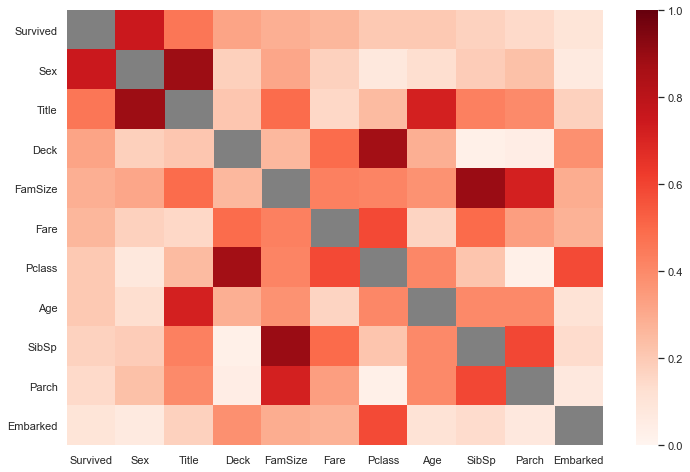

In [170]:
fig, ax = plotMatrix(phikMatrix, sortOn=target, mask=(phikMatrix == 1))

In [542]:
phikNoTarget = 1 - phikMatrix.drop(target, axis=0).drop(target, axis=1)
phikClusterer = AgglomerativeClustering(
    affinity='precomputed', linkage='average', 
    n_clusters=None, distance_threshold=0.25)

# Associate cluster labels with features names
labelledClusters = (pd.DataFrame(
    {'cluster': phikClusterer.fit(phikNoTarget).labels_, 
     'feature': phikNoTarget.index}))

# Add association with target and sort
labelledClusters = (
    pd.merge(phikMatrix[target].drop(target), labelledClusters, 
             left_index=True, right_on='feature')
    .sort_values(target, ascending=False))
    
# Group by cluster and print clustered features.
# Features are ordered in a cluster according to their association with the target
# and cluster are order by their mean association with target.
clusterFeatures = labelledClusters.groupby('cluster')
(pd.concat([clusterFeatures['feature'].apply(list), 
           clusterFeatures[target].mean()], axis=1)
    .sort_values('Survived', ascending=False)
    .style.background_gradient(cmap='Blues'))

,feature,Survived
cluster,,
1,"['Sex', 'Title']",0.606
2,['famSurvive'],0.356
7,['famDie'],0.306
6,['Fare'],0.265
0,"['Deck', 'Pclass']",0.263
3,"['FamSize', 'SibSp']",0.231
5,['Age'],0.203
8,['Parch'],0.147
4,['Embarked'],0.100


### Building a model
 - Here we build a custom transformer incorporating all of the preprocessing steps.
  - Using a custom transformer within a pipeline helps prevent data leakage and make it easy to run the pipeline on test datasets.

In [19]:
class GroupImputer(BaseEstimator, TransformerMixin):
    """ Extension of SimpleImputer to optionally impute 
        values by group and return a pandas Series. """
    
    def __init__(self, variable, by=[], strategy='median'): 
        self.variable = variable
        self.by = by
        if strategy == 'most_frequent':
            self.strategy = lambda x: x.mode().sample(1).values[0]
        else:
            self.strategy = strategy
        self.maps = []

    def fit(self, X, y=None):
        # Store impute for ungrouped data
        self.simpleImpute = X[self.variable].agg(self.strategy)
        # Store maps for all grouping levels
        for i in range(len(self.by), 0, -1):
            subBy = self.by[:i]
            mapper = X.groupby(subBy)[self.variable].agg(self.strategy)
            if i == 1:
                mapper = {(k,): v for k, v in mapper.to_dict().items()}
            self.maps.append((subBy , mapper))
        return self

    def transform(self, X, y=None):
        imputed = X[self.variable]
        for (by, mapper) in self.maps:
            fillVals = X[by].apply(tuple, axis=1).map(mapper)
            imputed = imputed.fillna(fillVals)
            if not imputed.isnull().values.any():
                break
        else:
            # Replace remaining NaN (with ungrouped)
            imputed = imputed.fillna(self.simpleImpute)
        return imputed

### NoTransformer
 - In this analysis we make use of the ColumnTransformer to explicity define a pre-processing step for each feature.
 - Any features not included in the ColumnTransformer are dropped.
 - This transformer allows us to pass the data through the ColumnTransformer and retain features that do not need pre-processing.

In [20]:
class NoTransformer(BaseEstimator, TransformerMixin):
    """ Dummy transformer """
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X

In [21]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """ Custom imputation and feature engineering 
        of Titanic dataset """
    
    def __init__(self):
        self._imputes = {}
        

    def initData(self, X):
        """ Feature engineering required for both fit & transform """
        X['Title'] = X['Name'].apply(self.getTitle)
        X['Surname'] = X['Name'].apply(self.getSurname)
        X['FamSize'] = X['Parch'] + X['SibSp'] + 1
        X['ageGroup'] = X.apply(self.estimateAgeGroup, axis=1)

        
    def fit(self, X, y=None):
        X = X.copy()
        self.initData(X)
        # Store surnames of all adult males (with families) that survived
        maleSurviveWithFam = (
            (X['Sex'] == 'male') & (X['Title'] != 'Master') & 
            (y == 1) & (X['FamSize'] > 1))
        self.maleNames = X.loc[maleSurviveWithFam, 'Surname']
        # Store surnames of all women and children (with families) that died
        femaleDieWithFam = (
            ((X['Sex'] == 'female') | (X['Title'] == 'Master')) &
            (y == 0) & (X['FamSize'] > 1))
        # Store surnames of all females (with families) that died
        self.femaleNames = X.loc[femaleDieWithFam, 'Surname']
        self._imputes['Age'] = GroupImputer(
            'Age', by=['ageGroup', 'Pclass'], strategy='median').fit(X)
        return self

    
    def transform(self, X, y=None):
        X = X.copy()
        self.initData(X)
        X['Age'] = self._imputes['Age'].transform(X)
        X['famSurvive'] = X['Surname'].isin(self.maleNames)
        X['famDie'] = X['Surname'].isin(self.femaleNames)
        X['Deck'] = X['Cabin'].apply(lambda x: x[0])
        # Boolean mask of any title NOT in list
        otherTitles = ~X['Title'].isin(['Mr', 'Miss', 'Mrs', 'Master'])
        # Replace non-standard titles with other to reduce cardinality.
        X.loc[otherTitles, 'Title'] = 'Other'
        return X

    
    def estimateAgeGroup(self, X):
        """ Estimate age/sex group by title for age imputation """
        # Assume unmarried with parents is a girl
        if (X['Title'] == 'Miss') & (X['Parch'] > 0):
            return 'girl'
        elif (X['Title'] == 'Master'):
            return 'boy'
        elif (X['Sex'] == 'male'):
            return 'man'
        else:
            return 'woman'    
        
        
    def getTitle(self, x):
        """ Extract title from name """
        return re.split(',|\.', x)[1].strip()
    
    
    def getSurname(self, x):
        """ Extract surname from name """
        return re.split(',', x)[0].strip()

### Read training data
 - Seperate feature matrix and target vector.
 - Split into training and validation datasets.
   - Since test_train_split returns a view we run the result through map() to yeild a true copy of each.
 

In [22]:
X = pd.read_csv(trainPath, index_col=index, dtype=dtypes)
y = X.pop(target)

split = train_test_split(X, y, random_state=0, train_size=0.8, test_size=0.2)
X_train, X_valid, y_train, y_valid = map(lambda x: x.copy(), split)

In [23]:
EmbarkedTransformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encode', OneHotEncoder(
        handle_unknown='ignore', categories=[['C', 'Q', 'S']]))
])
DeckTransformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encode', OneHotEncoder(
        handle_unknown='ignore', categories=[['C', 'E', 'G', 'D', 'A', 'B', 'F', 'T']]))
])
AgeDiscretizer = Pipeline(steps=[
    ('discrete', KBinsDiscretizer(encode='ordinal', strategy='kmeans'))
])

In [757]:
transformers = ([
    ('Pclass',   OneHotEncoder(handle_unknown='ignore', categories=[[1, 2, 3]]),  ['Pclass']),
    ('Title',    OneHotEncoder(handle_unknown='ignore', categories=[['Mr', 'Miss', 'Mrs', 'Master', 'other']]),  ['Title']),
    ('Embarked', EmbarkedTransformer, ['Embarked']),
    ('Deck',     DeckTransformer, ['Deck']),
    ('Age',      AgeDiscretizer, ['Age']),
    ('None',     NoTransformer(), ['famDie', 'famSurvive', 'FamSize']),
])
featureTransformer = ColumnTransformer(transformers=transformers, remainder='drop', sparse_threshold=0)

In [758]:
# Define a preModel pipeline distinct from modelling step
preProcessor = Pipeline(steps=[
    ('engineer',        FeatureEngineer()),
    ('columnTransform', featureTransformer),
])

### Assess feature importance
 - This function takes a preProcessor pipeline and a tree estimator to assess feature importance 

In [753]:
def plotFeatureImportance(X, y, prePreprocessor, estimator, vline=None):
    """ Run decision tree ensemble method on a preModel 
        pipline and plot feature importance """
    pipeline = Pipeline(steps=[
        ('prePreprocessor', prePreprocessor),
        ('selector',        estimator)])
    clf = pipeline.fit(X, y)
    columnTransformer = (
        clf.named_steps['prePreprocessor'].named_steps['columnTransform'])
    try:
        selector = clf.named_steps['prePreprocessor'].named_steps['selector']
    except KeyError:
        selector = None
    featureNames = getFeatureNames(columnTransformer, selector)
    features = (pd.DataFrame(
        {'feature': featureNames,
         'importance': clf.named_steps['selector'].feature_importances_})
        .sort_values(by=['importance'], ascending=False))
    
    print(f'Total unfiltered features: {len(featureNames)}')
    fig, ax = plt.subplots()
    sns.barplot(y='feature', x='importance', data=features, ax=ax)
    if vline is not None:
        ax.axvline(vline)
    ax.set_ylabel('')
    ax.set_xlabel('Feature importance')
    fig.tight_layout()

In [754]:
def getFeatureNames(columnTransformer, selector=None):
    """ Extract feature names from column transformer object. 
        If transformers are pipelines the one-hot encoding step
        should be last step of that pipeline.
    """
    colNames = np.array([])
    for tupleTransformer in columnTransformer.transformers_[:-1]:
        if isinstance(tupleTransformer[1], Pipeline): 
            transformer = tupleTransformer[1].steps[-1][1]
        else:
            transformer = tupleTransformer[1]
        try:
            # One hot encoded names have x0_, x1_ etc.
            names = transformer.get_feature_names()
            trueNames = tupleTransformer[-1]
            # Get dict mapping transformed name to true name
            nameMap = {f'x{i}_' : name for i, name in enumerate(trueNames)}
            # Swap transformed name with true name
            for i, name in enumerate(names):
                prefix = name[:3]
                names[i] = f'{nameMap[prefix]}_{name[3:]}'
        except AttributeError:
            names = tupleTransformer[2]
        # This is for kBinDiscretizers, which have n_bins_ method
        if (isinstance(transformer, KBinsDiscretizer)
                and transformer.encode != 'ordinal'):
            if transformer.encode != 'ordinal':
                nBins = transformer.n_bins_
                newNames = []
                for col, n in zip(names, nBins):
                    newNames = [f'{col}-{i}' for i in range(n)]
                names = newNames
        colNames = np.append(colNames, names)
    if selector is not None:
        colNames = colNames[selector.get_support()]
    return colNames

Total unfiltered features: 24


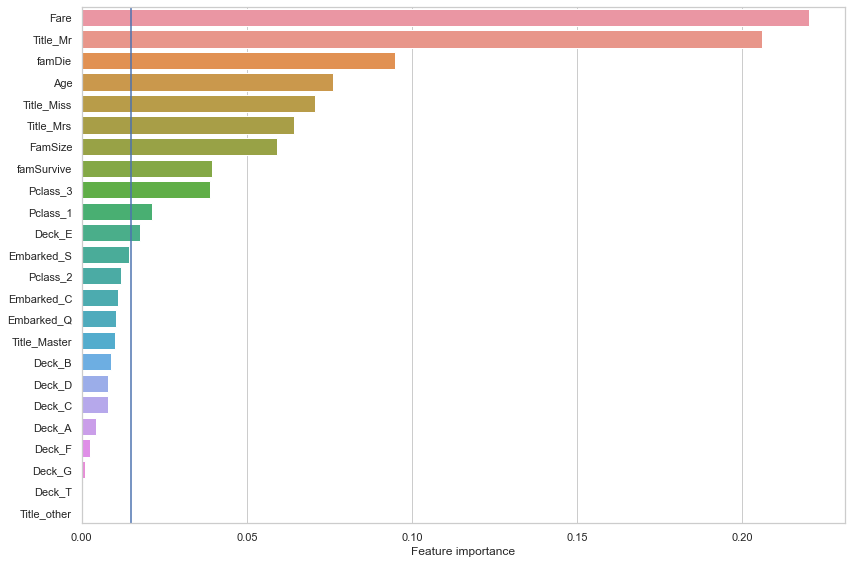

In [755]:
# Note the plotFeatureImportance function assumes the columnTransformer is named 'columnTransform'
# Future update could loop through steps and find the ColumnTransformer object
selectEstimator = RandomForestClassifier(random_state=1, n_estimators=500, max_features='sqrt')
plotFeatureImportance(X_train, y_train, preProcessor, selectEstimator, 0.015)

### Perform recursive feature elimination
  - Combine the preProcessor pipeline with feature selector.
  - Run feature selection and identify selected features.

In [691]:
# Configure the cross-validation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=1)
nJobs = 4

In [692]:
featureSelector = Pipeline(steps=[
    ('preProcess',    preProcessor),
    ('selector',      RFECV(selectEstimator, cv=cv, scoring='accuracy')),
])
# Fit data to pipeline
featureSelector.fit(X_train, y_train)

Pipeline(steps=[('preProcess',
                 Pipeline(steps=[('engineer', FeatureEngineer()),
                                 ('columnTransform',
                                  ColumnTransformer(sparse_threshold=0,
                                                    transformers=[('Pclass',
                                                                   OneHotEncoder(categories=[[1,
                                                                                              2,
                                                                                              3]],
                                                                                 handle_unknown='ignore'),
                                                                   ['Pclass']),
                                                                  ('Title',
                                                                   OneHotEncoder(categories=[['Mr',
                                                                                              'Miss',
                                                                                              'Mrs',
                                                                                              'Master',
                                                                                              'other']],
                                                                                 handle_unknown='ignore'),
                                                                   ['Title']),
                                                                  ('Embarked',...
                                                                   ['Deck']),
                                                                  ('Age',
                                                                   Pipeline(steps=[('discrete',
                                                                                    KBinsDiscretizer(encode='ordinal',
                                                                                                     strategy='kmeans'))]),
                                                                   ['Age']),
                                                                  ('None',
                                                                   NoTransformer(),
                                                                   ['famDie',
                                                                    'famSurvive',
                                                                    'FamSize'])]))])),
                ('selector',
                 RFECV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                       estimator=RandomForestClassifier(max_features='sqrt',
                                                        n_estimators=500,
                                                        random_state=1),
                       scoring='accuracy'))])

#### View transformed data
 - Here we view our transformed and feature filtered dataset as a sanity check prior to running the model.
 - The custom function 'getFeatureNames' processes a columnTransformer object to extract the original feature names.
  - This allows us to view the processed numpy matrix as a labelled dataframe.
  - Ref: https://github.com/scikit-learn/scikit-learn/issues/12525 

In [682]:
# Extract columnTransformer and selector to extract feature names
columnTransformer = featureSelector.named_steps['preProcess'].named_steps['columnTransform']
selector = featureSelector.named_steps['selector']
selectedFeatures = selector.get_support()
featureNames = getFeatureNames(columnTransformer, selector)
# Create dataframe of transformed data
transformedDF = pd.DataFrame(
    featureSelector.transform(X_train), 
    columns=featureNames)

# Symetric difference between 'with' and 'without selection'
allFeatures = set(getFeatureNames(columnTransformer))

eliminatedFeatures = allFeatures ^ set(featureNames)
print(f'Eliminated features: {eliminatedFeatures}')

transformedDF.head()

Eliminated features: {'Deck_A', 'Title_Master', 'Deck_G', 'Title_other', 'Deck_T', 'Deck_F', 'Deck_C'}


,Pclass_1,Pclass_2,Pclass_3,Title_Mr,Title_Miss,Title_Mrs,Embarked_C,Embarked_Q,Embarked_S,Deck_E,Deck_D,Deck_B,Age,FamSize
0,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00
1,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,2.00,1.00
2,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,2.00,3.00
3,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00
4,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00


### Estimator hypertuning
  - Build a fresh pipeline seperate from the feature selector.
  - The custom FeatureFilter() transformer filters unselected features.
  - We do this because we don't want to perform feature selection within a parameter search.

#### FeatureFilter
 - In the previous step we created a seperate pipeline to performed pre-processing and recursive feature elimination to determine optimal features to pass to the model.
   - This pipeline returns a boolean array of features selected.
 - The FeatureFilter transformer is included in the main pipeline to filter features before passing to the model.

In [683]:
class FeatureFilter(BaseEstimator, TransformerMixin):
    """ Filter columns by boolean mask """
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[:, self.columns]

In [684]:
fullModel = Pipeline(steps=[
    ('preProcess',    preProcessor),
    ('featureFilter', FeatureFilter(selectedFeatures)),
    ('model',         RandomForestClassifier(random_state=1)),
])

params = ({
    'preProcess__columnTransform__Age__discrete__n_bins':  range(2, 5),
    'model__n_estimators':      range(100, 1000, 10),
    'model__max_depth':         range(1, 20),
    'model__criterion':         ['gini', 'entropy'],
    'model__max_features':      range(1, len(featureNames) + 1),
})

gridSearch = RandomizedSearchCV(
    fullModel, params, scoring='accuracy', random_state=1,
    cv=cv, refit=True, n_jobs=nJobs, n_iter=100, verbose=1)
gridSearch.fit(X_train, y_train)

score = gridSearch.score(X_valid, y_valid)
print(f'Best score: {score:.3f}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   49.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.1min finished


Best score: 0.788


In [685]:
X_test = pd.read_csv(testPath, index_col=index, dtype=dtypes)
currentPredict = gridSearch.predict(X_test)

correct = pd.read_csv('submissionTrue.csv')['Survived']
myBest = pd.read_csv('submissionBest.csv')['Survived']
actualScore = (correct == currentPredict).sum() / len(correct)
print(actualScore)

0.7464114832535885


### BayesSearchCV
  - Note: current version of skopt (0.8.1) not compatible with scikit-learn 0.24.1

In [35]:
params = ({
    'model__n_estimators':      Integer(100, 1000),
    'model__max_depth':         Integer(3, 20),
    'model__criterion':         Categorical(['gini', 'entropy']),
    'model__max_features':      Integer(1, len(featureNames)),
})

gridSearch = BayesSearchCV(
    fullModel, params, scoring='accuracy', random_state=1,
    cv=cv, refit=True, n_jobs=nJobs, n_iter=50)
gridSearch.fit(X, y)

BayesSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
              estimator=Pipeline(steps=[('preProcess',
                                         Pipeline(steps=[('engineer',
                                                          FeatureEngineer()),
                                                         ('columnTransform',
                                                          ColumnTransformer(transformers=[('Pclass',
                                                                                           OneHotEncoder(categories=[[1,
                                                                                                                      2,
                                                                                                                      3]],
                                                                                                         handle_unknown='ignore'),
                                                                                           ['Pclass']),
                                                                                          ('Title',
                                                                                           OneHotEncoder(categories=[['Mr',
                                                                                                                      'Miss',
                                                                                                                      'Mrs',
                                                                                                                      'Master',
                                                                                                                      'oth...
              n_jobs=4, random_state=1, scoring='accuracy',
              search_spaces={'model__criterion': Categorical(categories=('gini', 'entropy'), prior=None),
                             'model__max_depth': Integer(low=3, high=20, prior='uniform', transform='identity'),
                             'model__max_features': Integer(low=1, high=9, prior='uniform', transform='identity'),
                             'model__n_estimators': Integer(low=100, high=1000, prior='uniform', transform='identity')})